In [6]:
###Code from phil to seek database entries and solve gfactors for the dima degeneracy issue
##download from gmail 20201206
######################################################################


#  PROGRAM TO FIND BEST FIT PARAMETERS TO STOKES VECTORS FROM M1 CORONAL LINES
#
#  1. GET OBSERVATIONS, ELONGATION AND STOKES VECTORS
#  2. IDENTIFY AND READ THE SPECIFIC ELONGATION FILE
#  3. COMPUTE CHI^2 


######################################################################
import os
import numpy as np
from scipy.io import FortranFile
from pylab import *
from astropy.io import ascii
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import matplotlib.ticker as mtick
import matplotlib.pylab as pylab
import warnings
import pickle
import time
import sys
#
np.set_printoptions(precision=3,suppress=False)
## to import the custom library in ipython
sys.path.insert(1, '/home/alin/Documents/physics_prog/cle/python/')
import importlib        ### to reload external files after changes are made within modules.
import cle_utils_phil
import cle_utils

In [7]:
def obs_fake(dbdir,yobs,counts):
    #
    # INPUTS  yobs, counts
    # 
    # Normally one would read from an observation file.
    # Instead in this case read from files gridobs, obs.dat, obs.hdr
    # Reads files 'obs.hdr' and filen (e.g. OB0100.DAT) for observations
    # from filename, i.e. 0100/1000 + 1 solar radii = 1.1 solar radii
    # The idea is to return data along a certain elongation y from Sun
    # from another PCA calculation from CLE.
    # The data returned are just
    #  sobs    -    an array of size [4*nuse, nobs], normalized to maximum = 1.0
    #  rms     -    an array of size (4*nuse]  uncertainties
    #               nuse = number of lines to use = nline by default
    #
    # header file

    g=cle_utils_phil.readhdr(dbdir+'db.hdr')
    g, ned, ngx, nbphi, nbtheta, nb, xed, gxmin,gxmax, bphimin, bphimax, \
        bthetamin, bthetamax, xb, nline, wavel  = cle_utils_phil.parsehdr(g)
    #
    #  set number of lines to use 
    #
    nuse=nline
    iy=((yobs-1)*1000)
    so='%0*d' % (4, iy)
    fildb=dbdir+'DB'+so+'.DAT'
    #fildb=dbdir+'DB1050.DAT'
    f = open(fildb, 'rb')
    #
    d = np.fromfile(file=f, dtype=np.float32)
    data=d
    #dls = np.fromfile(file='dbcle/fe13ls/'+ 'DB'+so+'.DAT',dtype=np.float32)
    #print(dls.shape,d.shape)
    print(d.shape)
    shap=[ned,ngx,nbphi,nbtheta,nb,nline,5]
    d=np.reshape(d,shap)
    print(d.shape)
    d=d[3,:,:,:,0,:,:]
    print(d.shape)
    #datals=np.reshape(dls,shap)

    #d=data[4,:,:,:,:] /datals[4,:,:,:,:] -1.
    #d=np.reshape(d,ngx*nbphi*nbtheta*nline*4)
    #print(d.shape)
    #plt.hist(d,bins=100)
    #print(d.max(),d.min())
    
    print(d.shape)
    lam1=10747.
    lam2=10798.
    g0=1.
    g1=3.
    g2=5.
    gbar0=1.5
    gbar1=3.0
    if(xtra == 'ls'):
        gbar1=1.5

    gbar0*=lam1
    gbar1*=lam2
    print(stats.tstd(d))
    sig1=d[:,23,73,0,4]
    sig2=d[:,23,73,1,4]
    i1=d[:,23,73,0,0]
    i2=d[:,23,73,1,0]
    q1=d[:,23,73,0,1]
    q2=d[:,23,73,1,1]
    u1=d[:,23,73,0,2]
    u2=d[:,23,73,1,2]
    v1=d[:,23,73,0,3]
    v2=d[:,23,73,1,3]
    l1=np.sqrt(q1*q1+u1*u1)
    l2=np.sqrt(q2*q2+u2*u2)
    r1=v1/(i1+l1)/gbar0
    r2=v2/(i2+l2)/gbar1
    r=r1/r2
    #r=v1/v2
    #r = np.reshape(r,ngx)
    print(r.shape)
    #plt.plot(r)
    r1=v1/(i1-l1)/gbar0
    r2=v2/(i2-l2)/gbar1
    r=r1/r2
    print(r)
    #r=v1/v2
    #r = np.reshape(r,ngx)
    #plt.plot(r,'-o')
    print(fildb)
    plt.plot(sig1)
    plt.plot(sig2)
    
    #
    #uniq,counts=np.unique(dtest1,return_counts=True)
    #print(counts,counts.sum())
    #plt.plot(counts)
    

    sys.exit()
    #
    # get stokes data s and alignments
    # the indices i,j,k,l are picked at random
    #
    index=917368 
    oindex=index
    i,j,k,l,m= cle_utils_phil.params(index,g)
    s0=data[i,j,k,l,m,0,:4]
    s1=data[i,j,k,l,m,1,:4]
    #xs1*=0.
    sobs=np.append(s0,s1)  # physical units

    sobs/=sobs[0]          # normalized
    sobs*=counts           # number of counts in each sobs
    
    p=cle_utils_phil.physa(oindex,yobs,g)
    i,j,k,l,m = cle_utils_phil.params(oindex,g)
    ss=data[i,j,k,l,0,:4]
    for ij in range(-1,1):
        pobs=cle_utils_phil.physa(oindex+ij*nb*3,yobs,g) 
        #print(pobs)
        #print('ThetaB = ',pobs[4])
        i,j,k,l,m = cle_utils_phil.params(oindex+ij*nb,g)
        s0=data[i,j,k,l,m,0,:5] 
        s1=data[i,j,k,l,m,1,:5]
        s0/=s0[0]
        s1/=s0[0]
        
        i0=s0[0]
        l0=sqrt( s0[1]*s0[1]+s0[2]*s0[2] )
        v0=s0[3]

        i1=s1[0]
        l1=sqrt( s1[1]*s1[1]+s1[2]*s1[2] )
        v1=s1[3]
        str=''
        if(s0[4] <0 and s1[4] < 0):str='--'
        if(s0[4] <0 and s1[4] > 0):str='-+'
        if(s0[4] >0 and s1[4] < 0):str='+-'
        if(s0[4] >0 and s1[4] > 0):str='++'
        if(str == '--'): print("ratio ",str,(i0-l0)*v1/v0/(i1-l1))
        if(str == '++'): print("ratio",str,(i0+l0)*v1/v0/(i1+l1))
        if(str == '-+'): print("ratio",str,(i0-l0)*v1/v0/(i1+l1))
        if(str == '+-'): print("ratio",str,(i0+l0)*v1/v0/(i1-l1))

        j0=0.
        j1=1.
        g0=1.
        g1=1.5
        gb0=0.5*(g0+g1) + 0.25*(g1-g0)*(j1*(j1+1)-j0*(j0+1))
        j0=1.
        j1=2.
        g0=1.5
        g1=3.
        gb1=0.5*(g0+g1) + 0.25*(g1-g0)*(j1*(j1+1)-j0*(j0+1))
        F1=3./4.*(j1*(j1+1)-j0*(j0+1)-2.)*(g1-g0)
        #print("g1,g0,gb1,gb0,F1,l1/i1",g1,g0,gb1,gb0,F1,l1/i1)

        n1=-F1*l1

        d0=gb1*(i1+l1)
        d1=gb0*(i0+l0)*v1/v0
        sin2=2.* n1 / 3/ ( d0-d1)

        #print("n1,d0,d1,d0-d1\n",n1,d0,d1,d0-d1)
        print("sin2 ThetaB = ",0., sin2)
        print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

        d0=gb1*(i1-l1)
        d1=gb0*(i0+l0)*v1/v0
        sin2=2.*  n1 / 3/ ( d0-d1)

        print("sin2 ThetaB = ",0., sin2)
        print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

        d0=gb1*(i1-l1)
        d1=gb0*(i0-l0)*v1/v0
        sin2=2.*  n1 / 3/ ( d0-d1)

        print("sin2 ThetaB = ",0., sin2)
        print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

        d0=gb1*(i1+l1)
        d1=gb0*(i0-l0)*v1/v0
        sin2=2.*  n1 / 3/ ( d0-d1)

        print("sin2 ThetaB = ",0., sin2)
        print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))
#    #sys.exit()
#
    #
    # First, here is variance of each state with counts electrons
    #
    variance = counts
    #
    # Here is variance vars in ((I+S) - (I-S))/2 = S, in counts
    #
    vars = (variance +variance)/2.
    #
    # here is the variance in y = S/I:  var(y)/y^2 = var(S)/S^2 + var(I)/I^2
    #
    vary =  vars/sobs**2 + variance/sobs[0]**2
    vary *= (sobs/sobs[0])**2
    rms=sqrt(vary)
    #
    # Now add noise to the fake observations
    #
    sobs = sobs * ( 1. + rms*np.random.normal(0.,1,sobs.shape) )
    # one realization 
    #sobs *= (1. +rms*[0. , -1.73,  0.05, -0.13,  1.44,  1.29, -1.11, -1.02])
    sobs/=counts
    sobs[0]=1.
    #
    # Now fix the rms values for the denominator in the chi2 calculation
    # this is for each stokes value
    #
    ######################################################################
    # finished observations, which consist only of
    #
    #  nuse, sobs, rms
    #
    # yobs is the elongation in Rsun of the observed y-position 
    # index is the index of the calculation used to make fake obs
    #       (not needed for real observations)
    #
    ######################################################################
    print("\n")
    strc="{:0.1f}".format(log10(counts))

    print('Fake observations: log counts per state =',strc)
    print('S     ', [ "{:9.2e}".format(x) for x in sobs ])
    #print('rms   ',[ "{:9.2e}".format(x) for x in rms ])
    print('rms/s ',[ "{:9.2e}".format(x) for x in rms/sobs ])
    print("\n")
    
    return [nuse,sobs,rms,index]


######################################################################
# NEEDED FUNCTIONS END

In [8]:
def obs_fake2(dbdir,yobs,counts):
    #
    # INPUTS  yobs, counts
    # 
    # Normally one would read from an observation file.
    # Instead in this case read from files gridobs, obs.dat, obs.hdr
    # Reads files 'obs.hdr' and filen (e.g. OB0100.DAT) for observations
    # from filename, i.e. 0100/1000 + 1 solar radii = 1.1 solar radii
    # The idea is to return data along a certain elongation y from Sun
    # from another PCA calculation from CLE.
    # The data returned are just
    #  sobs    -    an array of size [4*nuse, nobs], normalized to maximum = 1.0
    #  rms     -    an array of size (4*nuse]  uncertainties
    #               nuse = number of lines to use = nline by default
    #
    # header file

    g, ned, ngx, nbphi, nbtheta, xed, gxmin,gxmax, bphimin, bphimax, \
        bthetamin, bthetamax, xb, nline, wavel  = cle_utils.readhdr(dbdir+'db.hdr')
    #
    #  set number of lines to use 
    #
    nb=1
    nuse=nline
    iy=((yobs-1)*1000)
    so='%0*d' % (4, iy)
    fildb=dbdir+'DB'+so+'.DAT'
    #fildb=dbdir+'DB1050.DAT'
    f = open(fildb, 'rb')
    #
    d = np.fromfile(file=f, dtype=np.float32)
    data=d
    #dls = np.fromfile(file='dbcle/fe13ls/'+ 'DB'+so+'.DAT',dtype=np.float32)
    #print(dls.shape,d.shape)
    print(d.shape)
    shap=[ned,ngx,nbphi,nbtheta,nline,5]
    data=np.reshape(d,shap)    
#     d=np.reshape(d,shap)
#     print(d.shape)
#     d=d[3,:,:,:,:,:]
#     print(d.shape)
#     #datals=np.reshape(dls,shap)

#     #d=data[4,:,:,:,:] /datals[4,:,:,:,:] -1.
#     #d=np.reshape(d,ngx*nbphi*nbtheta*nline*4)
#     #print(d.shape)
#     #plt.hist(d,bins=100)
#     #print(d.max(),d.min())
    
#     print(d.shape)
#     lam1=10747.
#     lam2=10798.
#     g0=1.
#     g1=3.
#     g2=5.
#     gbar0=1.5
#     gbar1=3.0
#     if(xtra == 'ls'):
#         gbar1=1.5

#     gbar0*=lam1
#     gbar1*=lam2
#     print(stats.tstd(d))
#     sig1=d[:,23,73,0,4]
#     sig2=d[:,23,73,1,4]
#     i1=d[:,23,73,0,0]
#     i2=d[:,23,73,1,0]
#     q1=d[:,23,73,0,1]
#     q2=d[:,23,73,1,1]
#     u1=d[:,23,73,0,2]
#     u2=d[:,23,73,1,2]
#     v1=d[:,23,73,0,3]
#     v2=d[:,23,73,1,3]
#     l1=np.sqrt(q1*q1+u1*u1)
#     l2=np.sqrt(q2*q2+u2*u2)
#     r1=v1/(i1+l1)/gbar0
#     r2=v2/(i2+l2)/gbar1
#     r=r1/r2
#     #r=v1/v2
#     #r = np.reshape(r,ngx)
#     print(r.shape)
#     #plt.plot(r)
#     r1=v1/(i1-l1)/gbar0
#     r2=v2/(i2-l2)/gbar1
#     r=r1/r2
#     print(r)
#     #r=v1/v2
#     #r = np.reshape(r,ngx)
#     #plt.plot(r,'-o')
#     print(fildb)
#     plt.plot(sig1)
#     plt.plot(sig2)
    
    #
    #uniq,counts=np.unique(dtest1,return_counts=True)
    #print(counts,counts.sum())
    #plt.plot(counts)
    

    #sys.exit()
    #
    # get stokes data s and alignments
    # the indices i,j,k,l are picked at random
    #
    index=917368 
    oindex=index
    i,j,k,l= cle_utils.params(index,g)
    s0=data[i,j,k,l,0,:4]
    s1=data[i,j,k,l,1,:4]
    #xs1*=0.
    sobs=np.append(s0,s1)  # physical units

    sobs/=sobs[0]          # normalized
    sobs*=counts           # number of counts in each sobs
    print(sobs)
#     p=cle_utils_phil.physa(oindex,yobs,g)
#     i,j,k,l,m = cle_utils_phil.params(oindex,g)
#     ss=data[i,j,k,l,0,:4]
#     for ij in range(-1,1):
#         pobs=cle_utils_phil.physa(oindex+ij*nb*3,yobs,g) 
#         #print(pobs)
#         #print('ThetaB = ',pobs[4])
#         i,j,k,l,m = cle_utils.params(oindex+ij*nb,g)
#         s0=data[i,j,k,l,0,:5] 
#         s1=data[i,j,k,l,1,:5]
#         s0/=s0[0]
#         s1/=s0[0]
        
#         i0=s0[0]
#         l0=sqrt( s0[1]*s0[1]+s0[2]*s0[2] )
#         v0=s0[3]

#         i1=s1[0]
#         l1=sqrt( s1[1]*s1[1]+s1[2]*s1[2] )
#         v1=s1[3]
#         str=''
#         if(s0[4] <0 and s1[4] < 0):str='--'
#         if(s0[4] <0 and s1[4] > 0):str='-+'
#         if(s0[4] >0 and s1[4] < 0):str='+-'
#         if(s0[4] >0 and s1[4] > 0):str='++'
#         if(str == '--'): print("ratio ",str,(i0-l0)*v1/v0/(i1-l1))
#         if(str == '++'): print("ratio",str,(i0+l0)*v1/v0/(i1+l1))
#         if(str == '-+'): print("ratio",str,(i0-l0)*v1/v0/(i1+l1))
#         if(str == '+-'): print("ratio",str,(i0+l0)*v1/v0/(i1-l1))

#         j0=0.
#         j1=1.
#         g0=1.
#         g1=1.5
#         gb0=0.5*(g0+g1) + 0.25*(g1-g0)*(j1*(j1+1)-j0*(j0+1))
#         j0=1.
#         j1=2.
#         g0=1.5
#         g1=3.
#         gb1=0.5*(g0+g1) + 0.25*(g1-g0)*(j1*(j1+1)-j0*(j0+1))
#         F1=3./4.*(j1*(j1+1)-j0*(j0+1)-2.)*(g1-g0)
#         #print("g1,g0,gb1,gb0,F1,l1/i1",g1,g0,gb1,gb0,F1,l1/i1)

#         n1=-F1*l1

#         d0=gb1*(i1+l1)
#         d1=gb0*(i0+l0)*v1/v0
#         sin2=2.* n1 / 3/ ( d0-d1)

#         #print("n1,d0,d1,d0-d1\n",n1,d0,d1,d0-d1)
#         print("sin2 ThetaB = ",0., sin2)
#         print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

#         d0=gb1*(i1-l1)
#         d1=gb0*(i0+l0)*v1/v0
#         sin2=2.*  n1 / 3/ ( d0-d1)

#         print("sin2 ThetaB = ",0., sin2)
#         print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

#         d0=gb1*(i1-l1)
#         d1=gb0*(i0-l0)*v1/v0
#         sin2=2.*  n1 / 3/ ( d0-d1)

#         print("sin2 ThetaB = ",0., sin2)
#         print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))

#         d0=gb1*(i1+l1)
#         d1=gb0*(i0-l0)*v1/v0
#         sin2=2.*  n1 / 3/ ( d0-d1)

#         print("sin2 ThetaB = ",0., sin2)
#         print("     ThetaB = ", arcsin(sqrt(np.abs(sin2))))
#    #sys.exit()
#
    #
    # First, here is variance of each state with counts electrons
    #
    variance = counts
    #
    # Here is variance vars in ((I+S) - (I-S))/2 = S, in counts
    #
    vars = (variance +variance)/2.
    #
    # here is the variance in y = S/I:  var(y)/y^2 = var(S)/S^2 + var(I)/I^2
    #
    vary =  vars/sobs**2 + variance/sobs[0]**2
    vary *= (sobs/sobs[0])**2
    rms=sqrt(vary)
    #
    # Now add noise to the fake observations
    #
    sobs = sobs * ( 1. + rms*np.random.normal(0.,1,sobs.shape) )
    # one realization 
    #sobs *= (1. +rms*[0. , -1.73,  0.05, -0.13,  1.44,  1.29, -1.11, -1.02])
    sobs/=counts
    sobs[0]=1.
    #
    # Now fix the rms values for the denominator in the chi2 calculation
    # this is for each stokes value
    #
    ######################################################################
    # finished observations, which consist only of
    #
    #  nuse, sobs, rms
    #
    # yobs is the elongation in Rsun of the observed y-position 
    # index is the index of the calculation used to make fake obs
    #       (not needed for real observations)
    #
    ######################################################################
    print("\n")
    strc="{:0.1f}".format(log10(counts))

    print('Fake observations: log counts per state =',strc)
    print('S     ', [ "{:9.2e}".format(x) for x in sobs ])
    #print('rms   ',[ "{:9.2e}".format(x) for x in rms ])
    print('rms/s ',[ "{:9.2e}".format(x) for x in rms/sobs ])
    print("\n")
    
    return [nuse,sobs,rms,index]


######################################################################
# NEEDED FUNCTIONS END

In [17]:
######################################################################
# MAIN PROGRAM : some controlling parameters
#
importlib.reload(cle_utils_phil) 
importlib.reload(cle_utils) 
iplot=0  # to make pdf files in directory fitted (can be time consuming)
#
#  the number of counts which correspond to the
#  largest intensity in each of the nobs observations
#  for example: counts = 1.e8 gives rms fluctuations 10^-4 * max(intensity)
#
lab=['I','Q','U','V']
lab+=lab
s2d=180./np.pi

#choose xtra based on coupling scheme in db.
xtra='ls'
#xtra='mix'
# print('Enter ls or return')
# xtra=input()
chi2max=1.4
nstokes=4
dbdir='/home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db201_deg_121_fe13_mix/'
outdir='/home/alin/Documents/physics_prog/cle/test_cle_degeneracy/fitted/'
yobs=1.2090
iy=round((yobs-1)*1000)
so='%0*d' % (4, iy)
fildb=dbdir+'DB'+so+'.DAT'
#fildb=dbdir+'DB1050.DAT'
print(dbdir,outdir,yobs, fildb)

/home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db201_deg_121_fe13_mix/ /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/fitted/ 1.209 /home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db201_deg_121_fe13_mix/DB0209.DAT


In [ ]:
######################################################################
# LOOP OVER COUNTS
for ij in range(1,10):
          print('\n')
nb=1
lmin=6.
lmax=10.
l = np.arange(lmin,lmax,1)
fr=l*0.
kount=0
for lcounts in l:
    counts=10.**lcounts
    strc="{:0.1f}".format(lcounts)
    
    #
    #######################################################################
    #
    # 1. Read Observations: 
    #   
    #######################################################################
    #

    # sobs is the observed Stokes array (nline*4)
#counts=1.e10
#nuse,sobs,rms,oindex = obs_fake(dbdir,yobs,counts)
    #
    #
    #######################################################################
    #
    # 2. Read computed database for selected y-position 
    #
    #######################################################################
    #
    #
g=cle_utils_phil.readhdr(dbdir+'db.hdr')
g, ned, ngx, nbphi, nbtheta, nb, xed, gxmin,gxmax, bphimin, bphimax, \
    bthetamin, bthetamax, xb, nline, wavel  = cle_utils_phil.parsehdr(g)

#g, ned, ngx, nbphi, nbtheta, xed, gxmin,gxmax, bphimin, bphimax, \
#bthetamin, bthetamax, xb, nline, wavel  = cle_utils.readhdr(dbdir+'db.hdr')
#  set number of lines to use 
#
nuse=nline
#
shap=[4*nline,ned*ngx*nbphi*nbtheta*nb]
s=np.empty(shap)
#
file = open(fildb, 'rb')
#
dbd = np.fromfile(file=file, dtype=np.float32)
shape=[ned*ngx*nbphi*nbtheta*nb,nline,5]
data=np.reshape(dbd,shape)
#
# get stokes data s
# 
print(nline)
gbar0=1.5
gbar1=3.
g0=1.
g1=3.
g2=5.
if(xtra == 'ls'):
    gbar0=1.50
    gbar1=1.50

align0=data[:,0,4]
s0=data[:,0,:4]
l0=np.sqrt(s0[:,1]*s0[:,1] + s0[:,2]*s0[:,2])
i0=s0[:,0]
v0=s0[:,3]
r0= gbar0*v0/(i0+l0)

align1=data[:,1,4]
s1=data[:,1,:4]
l1=np.sqrt(s1[:,1]*s1[:,1] + s1[:,2]*s1[:,2])
i1=s1[:,0]
v1=s1[:,3]
r1= gbar1*v1/(i1+l1)

r=r0-r1
#plt.hist(r)
#sys.exit()
#
# shape of the stokes data sdb ("s database")
#  is (number of calcs, 4*nuse)
#
sdb=np.append(s0,s1,axis=1)                                                                     
#
# Always normalize to the strongest of the raw stokes parameter
# 
norm=sdb[:,0]
sdb = (sdb.T/norm.T).T
#
print(sdb[78,:])
plt.figure()
plt.plot(sdb[:,5])
#plt.ylim([-9e-14,5e-14])
plt.plot(sdb[:,6])
plt.plot(s1[:,0])
#plt.ylim([-9e-14,5e-14])
#plt.plot(s1[:,3])
######################################################################
#
#  Now find the matched data
#
######################################################################
#
#start=time.time()
#
#filn=outdir+so+str(oindex)+"C"+strc+".txt"
#os.system("rm "+filn)
#Fobj = open(filn,"a")
nn=16  # upper limit of number of nearest fits to permit, 
#
nc=sobs.shape[0]
dif=( (sdb-sobs) / rms )
sdif=dif*dif
#
# nf = number of degree of freedom in model: ne, x, bphi, btheta
ndata = nline*4 -1
ndof=4
denom=nline*4-1 - ndof
print("Ndata = ",ndata," N degrees of freedom = ",ndof)
#
chi2 = np.sum( sdif, axis=1)/denom
#
#  fast:
#     a = np.array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
#
#nnc=32
#ind = np.argpartition(chi2, nn)[:nnc]
#asrt= ind[np.argsort(chi2[ind])]
#
#




















2
[ 1.000e+00 -1.672e-01 -2.902e-08        nan  1.197e-02 -1.064e-03
 -1.846e-10        nan]


[nan nan nan ... nan nan nan]


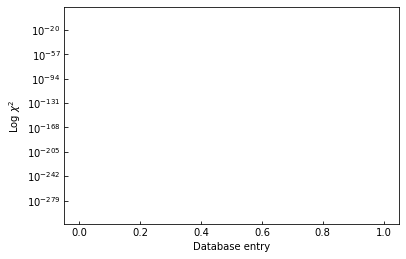

In [62]:
print(chi2)
#plt.figure()
plt.plot(chi2)
#plt.ylim([1e-2,4e4])
#plt.ylim([1e2,4e10])
plt.yscale('log')# 
plt.xlabel("Database entry")
plt.ylabel("Log $\chi^2$")
#plt.annotate("Fe XIII 1074nm and 1079nm line pair",xy=[1e5,2e4])
#plt.annotate("Mixed LS-jj coupling scheme",xy=[1e5,1e4])
#plt.annotate("Photon counts ~10$^{11}$",xy=[1e5,0.5e4])
plt.tick_params(axis="both",direction="in",which="both")



















(145800000,)
(10, 60, 180, 90, 3, 5)
(60, 180, 90, 3, 5)
(60, 180, 90, 3, 5)
[[[[4.581e-11 4.739e-13 4.208e-20 4.070e-22 4.835e-02]
   [2.037e-14 0.000e+00 0.000e+00 1.177e-25 1.629e-03]
   [3.167e-11 1.180e-14 5.746e-22 2.749e-22 1.629e-03]]

  [[4.581e-11 4.736e-13 9.469e-20 1.556e-16 4.824e-02]
   [2.037e-14 0.000e+00 0.000e+00 4.666e-20 1.625e-03]
   [3.167e-11 1.179e-14 1.678e-21 1.090e-16 1.625e-03]]

  [[4.581e-11 4.725e-13 7.888e-20 3.110e-16 4.792e-02]
   [2.037e-14 0.000e+00 0.000e+00 9.325e-20 1.614e-03]
   [3.167e-11 1.175e-14 1.257e-21 2.178e-16 1.614e-03]]

  ...

  [[4.581e-11 4.708e-13 8.788e-20 4.660e-16 4.737e-02]
   [2.037e-14 0.000e+00 0.000e+00 1.397e-19 1.595e-03]
   [3.167e-11 1.168e-14 1.535e-21 3.264e-16 1.595e-03]]

  [[4.581e-11 4.725e-13 8.681e-20 3.110e-16 4.792e-02]
   [2.037e-14 0.000e+00 0.000e+00 9.325e-20 1.614e-03]
   [3.167e-11 1.175e-14 1.544e-21 2.178e-16 1.614e-03]]

  [[4.581e-11 4.736e-13 8.834e-20 1.556e-16 4.824e-02]
   [2.03

SystemExit: 

/home/alin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


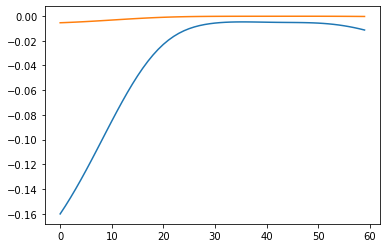

In [34]:
    ## sort the chi2
    asrt=np.argsort(chi2)

    ix=asrt[0]
    firstchi2=chi2[ix]
    #print("best s",sdb[ix,:], '\nbest chi2 = ', firstchi2)

    if(iplot > 0): fig, (ax1, ax2) = plt.subplots(2, 1)

    grid=g
    grid, ned, ngx, nbphi, nbtheta, nb, xed, gxmin,gxmax, bphimin, bphimax, \
        bthetamin, bthetamax, xb, nline, wavel  = cle_utils_phil.parsehdr(grid)

    s2d=180./np.pi

    
    phi0=-0.5*arctan2(sobs[2],sobs[1])
    np.savetxt(Fobj,[phi0,np.pi+phi0],fmt='Phi from  U/Q =%+.3f')
    np.savetxt(Fobj,sdb[ix], fmt='%+.2e', newline=" ")
    Fobj.write("\n")
    Fobj.write("      Observation    chi2     Ne        y       x    Bphi    Bthet   |B|")
    Fobj.write("\n")

    np.savetxt(Fobj,[oindex,oindex], fmt='%7i', newline=" ")
    np.savetxt(Fobj,[0.], fmt='%+.2e', newline=" ")
    led,gy,gx,bphi,btheta,b = cle_utils_phil.physa(oindex,yobs,grid)
    ph=cle_utils_phil.physa(oindex,yobs,grid)
    print('Physics',ph) # [ "{:+0.2e}".format(x) for x in ph ])
    np.savetxt(Fobj,[cle_utils_phil.physa(oindex,yobs,grid)],fmt='%+7.2f', newline=" ")
    Fobj.write("\n")
    Fobj.write("\n")
    si=0
    Fobj.write("      O       C      chi2     Ne        y       x    Bphi    Bthet   |B|   POS AZ LOS THETA RMS dobs")
    Fobj.write("\n")
    
    while (si <= nn):
        ix=asrt[si]
        dd=chi2[ix]
        ddi= "{:0.2e}".format(dd)
        if(dd < chi2max):
            sdif=sdb[ix,:]-sdb[oindex,:]
            np.savetxt(Fobj,[oindex,ix], fmt='%7i', newline=" ")
            np.savetxt(Fobj,[chi2[ix]], fmt='%+.2e', newline=" ")
            led,gy,gx,bphi,btheta,b = cle_utils_phil.physa(ix,yobs,grid)
            np.savetxt(Fobj,[cle_utils_phil.physa(ix,yobs,grid)],fmt='%+7.2f', newline=" ")

            
                    #
            # in CLE frame, bx,by,bz
            #
            bx=np.cos(bphi)*np.sin(btheta)
            by=np.sin(bphi)*np.sin(btheta)
            bz=cos(btheta)
            los=arccos(bx)
            pos=np.arctan2(by,bz)
            #
            np.savetxt(Fobj, [pos,los],fmt='%+7.3f', newline=" ")
            np.savetxt(Fobj, [stats.tstd(sdif)],fmt='%9.1e',newline=' ')
            Fobj.write("\n")
            np.savetxt(Fobj,sdif, fmt='%+.2e', newline=" ")
            Fobj.write("\n")
            Fobj.write("\n")

        if(iplot > 0):
            text="fit="+str(ix)+" $\chi^2$="+ddi
            if(si ==0):
                ax1.plot(sobs,'.')
                text="Obs sp="+str(oindex)+" fit="+str(ix)+" $\chi^2$="+ddi
            if(si <= 2):
                    ax1.plot(sdb[ix,:],label=text)
                    ax1.errorbar(np.arange(nc),sobs,yerr=rms,fmt='bo')
                    ax1.legend(fontsize=7)
                    ax1.set_xticks(np.arange(8))
                    ax1.set_xticklabels(lab)
            if(si ==0): ax2.plot(dif[ix,:],'.-',label="(O-N)/sigma")
            ax2.legend(fontsize=7)
            ax2.set_xticks(np.arange(8))
            ax2.set_xticklabels(lab)
            si=si+1
            
    if(iplot > 0):
        filen=outdir+'fit'+so+str(oindex)+"C"+strc
        print("Saving ", filen+".pdf")
        savefig(filen+".pdf")
        plt.close()
        #
    Fobj.close()
    dt= "{:3.2f}".format(time.time()-start)
    print(dt,' seconds for chi2')
    start=time.time()
                
    ######################################################################
    # Now here we examine the statistics of these apparent "fits"
    ######################################################################
    ok=np.argwhere(chi2 < chi2max)
    nok=ok.size
    ntot=chi2.size
    fr[kount]=np.float32(nok)/chi2.size
    print(fr[kount],' <--- fraction of ok fits, log counts=',strc,'nok=',nok,' ntot=',ntot)
    #
    d=np.zeros([6,nok])
    pobs= cle_utils_phil.physa(ix,yobs,grid)
    #print("assigning physical parameters..")
    for n in range(0,nok):
        ix=(ok[n])[0]
        a,b,c,dd,e,f = cle_utils_phil.physa(ix,yobs,grid)
        d[0,n] = a
        d[1,n] = b
        d[2,n] = c
        d[3,n] = dd
        d[4,n] = e
        d[5,n] = f 

    ttext=['log$_{10}N_e$','y (pos)','x (LOS)','$\Phi_B$','$\Theta_B$','B']
    fig, axs = plt.subplots(2,3,tight_layout=True)
    title=strc
    #
    plt.rcParams.update({'font.size': 7})

    pobs=cle_utils_phil.physa(oindex,yobs,g) 
    scounts='log counts = '+strc+' '

    f=np.array([1,1,1,1,1,1])

    alpha=.7
    for i in range(0,6):
        j=int(i/3)
        k=int(i-j*3)
        axs[j,k].hist(d[i,:]*f[i],label=text[i],alpha=alpha,density=0,bins=50,align='left')

        if i > 0: scounts=''
        axs[j,k].set_xlabel(ttext[i])
        axs[j,k].set_title(scounts)
        
        yr = axs[j,k].get_ylim()
        ij=0
        xr=[0.,0.]+pobs[i]*f[i]
        axs[j,k].plot(xr, yr)

#
    print('Physcs',pobs*f) # [ "{:+0.2e}".format(x) for x in ph ])

    filen=outdir+so+'hist'+xtra+str(oindex)+"C"+strc
    #print("Saving ", filen+".pdf")
    savefig(filen+".pdf")
    plt.close()
#    os.system("open "+filen+".pdf")
    dt= "{:3.2f}".format(time.time()-start)
    print(dt,' seconds for search')
    kount+=1

print('GASP!')    
#

print('\n','\n number solns=',fr*ntot,'\n')
plt.plot(l,log10(fr*ntot),'-o')
plt.title(str(oindex) + " " +xtra+ str(pobs))
plt.ylabel('Log # acceptable solutions ')
plt.xlabel('Log counts')
filen=outdir+so+'stats'+xtra+str(oindex)
print("Saving ", filen+".pdf")
savefig(filen+".pdf")
plt.close()
os.system("open "+filen+".pdf")
os.system("cat "+outdir+"030577368C7.0.txt")
#